In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats
import re
from scipy.stats.stats import pearsonr
#import rpy2.robjects as robjects
import random
from statsmodels.stats.multitest import fdrcorrection
import os
import seaborn as sns
#import gseapy as gs
from scipy.stats import norm
from scipy.stats import mannwhitneyu as mwu

In [6]:
#Read in the file to convert ensemble genes to gene IDs.
ens_to_gene = pd.read_csv("ensembl_to_gene_human.txt", sep = "\t")
d = {}
for index, row in ens_to_gene.iterrows():
    d[row[0]] = row[1]
#Load the list of all the genes in the GTEX file.
GTEX = pd.read_csv("GTEX_Have.txt", sep = "\t")
keep_tex = []
#Load the list of all the genes in the Stein Neural ASE file.
Stein = pd.read_csv("ASE_all_countmatrix_collapsed_gene_a1.txt", sep = "\t")
keep_stein = []
for index, row in GTEX.iterrows():
    j = row[0].split(".")[0]
    if j in d.keys():
        add = d[j]
        keep_tex.append(add)
for index, row in Stein.iterrows():
    keep_stein.append(row[1])

In [7]:
#Load Rachel's counts files
rachel = pd.read_csv("hyCS_GRCh38_Rachel_Data_No_Total.txt", sep = "\t").transpose()
rachel.columns = rachel.loc["gene"]
rachel.drop("gene", axis = 0, inplace = True)
rachel.head()

gene,3.8-1.2,3.8-1.4,3.8-1.5,5-HT3C2,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bA395L14.12
RA7_D50_HL2-16_human,0,0,0,0,113,94,3,323,19,1,...,255,48,193,446,7,761,3,1005,273,0
RA7_D50_HL2-16_chimp,0,0,0,0,78,78,1,358,9,3,...,166,0,147,611,11,914,1,1185,239,0
RA8_D50_HL1-29_human,0,0,0,0,117,62,0,129,17,1,...,124,2,173,278,4,513,4,617,174,0
RA8_D50_HL1-29_chimp,0,0,0,0,75,49,0,218,6,0,...,93,0,151,355,3,650,4,665,174,0
RA8_D50_HL2-16_human,0,0,0,0,151,60,7,501,23,0,...,135,34,220,275,10,419,9,746,198,0


In [8]:
#Load David's counts files.
david = pd.read_csv("David_Counts_Table.csv").transpose()
david.columns = david.loc["gene"]
david.drop("gene", axis = 0, inplace = True)
david.head()

gene,3.8-1.2,3.8-1.4,3.8-1.5,5-HT3C2,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bA395L14.12
iPSC_Hy1_25_rep1_human,0,0,0,0,39,40,0,1,8,129,...,1199,27,176,541,20,450,3917,552,472,0
iPSC_Hy1_25_rep1_chimp,0,0,0,0,70,49,0,13,19,50,...,658,24,136,519,51,753,4570,423,477,0
iPSC_Hy1_25_rep2_human,0,0,0,0,65,68,0,21,1,101,...,2416,31,310,695,28,535,6926,703,580,0
iPSC_Hy1_25_rep2_chimp,0,0,0,0,92,66,0,40,13,33,...,1302,21,178,796,87,980,8019,549,686,0
iPSC_Hy1_29_rep1_human,0,0,0,0,50,46,0,3,5,178,...,1142,24,139,447,27,418,3901,456,424,0


In [9]:
#Load the things we need to filter.
#We filter genes that showed mapping bias and genes on frequently duplicated chromosomes.
hy = pd.read_csv('hyCS_mapping_bias.csv')
ip = pd.read_csv('hyiPSC_mapping_bias.csv')
chr18 = pd.read_csv("chr18_human_gene_positions_named.txt", sep = "\t")
chr20 = pd.read_csv("chr20_human_gene_positions_named.txt", sep = "\t")
hycs_bias = []
ipsc_bias = []
chr18_chr20 = []
for index, row in hy.iterrows():
    hycs_bias.append(row[0])
for index, row in ip.iterrows():
    ipsc_bias.append(row[0])
for index, row in chr18.iterrows():
    chr18_chr20.append(row[0])
for index, row in chr20.iterrows():
    chr18_chr20.append(row[0])

In [10]:
#Get the D50 counts and create lists to prepare for filtering.
#Require an average number of reads equal to 25 in either humans or chimps to prevent inaccurate ASE estimation.
D50 = []
D50_h = []
l_D50_h = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D50" in index:
        D50.append([index] + list(row))
    if "D50" in index and "human" in index:
        D50_h.append([index] + list(row))
df_50_h = pd.DataFrame(D50_h).set_index(0)
df_50_h.columns = rachel.columns
df_50_h = df_50_h.transpose()
df_50 = pd.DataFrame(D50).set_index(0)
df_50.columns = rachel.columns
df_50 = df_50.transpose()
for index, row in df_50_h.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D50_h.append(index)
        
D50_c = []
l_D50_c = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D50" in index and "chimp" in index:
        D50_c.append([index] + list(row))
df_50_c = pd.DataFrame(D50_c).set_index(0)
df_50_c.columns = rachel.columns
df_50_c = df_50_c.transpose()
for index, row in df_50_c.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D50_c.append(index)

In [11]:
#Repeat for D100
D100 = []
D100_h = []
l_D100_h = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D100" in index:
        D100.append([index] + list(row))
    if "D100" in index and "human" in index:
        D100_h.append([index] + list(row))
df_100_h = pd.DataFrame(D100_h).set_index(0)
df_100_h.columns = rachel.columns
df_100_h = df_100_h.transpose()
df_100 = pd.DataFrame(D100).set_index(0)
df_100.columns = rachel.columns
df_100 = df_100.transpose()
for index, row in df_100_h.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D100_h.append(index)
        
D100_c = []
l_D100_c = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D100" in index and "chimp" in index:
        D100_c.append([index] + list(row))
df_100_c = pd.DataFrame(D100_c).set_index(0)
df_100_c.columns = rachel.columns
df_100_c = df_100_c.transpose()
for index, row in df_100_c.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D100_c.append(index)

In [12]:
#Repeat for D150
D150 = []
D150_h = []
l_D150_h = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D150" in index:
        D150.append([index] + list(row))
    if "D150" in index and "human" in index:
        D150_h.append([index] + list(row))
df_150_h = pd.DataFrame(D150_h).set_index(0)
df_150_h.columns = rachel.columns
df_150_h = df_150_h.transpose()
df_150 = pd.DataFrame(D150).set_index(0)
df_150.columns = rachel.columns
df_150 = df_150.transpose()
for index, row in df_150_h.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D150_h.append(index)
        
D150_c = []
l_D150_c = []
avg_reads = 25
for index, row in rachel.iterrows():
    if "D150" in index and "chimp" in index:
        D150_c.append([index] + list(row))
df_150_c = pd.DataFrame(D150_c).set_index(0)
df_150_c.columns = rachel.columns
df_150_c = df_150_c.transpose()
for index, row in df_150_c.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_D150_c.append(index)

In [13]:
#Repeat for CNCC
CNCC = []
CNCC_h = []
l_CNCC_h = []
avg_reads = 25
for index, row in david.iterrows():
    if "CNCC" in index:
        CNCC.append([index] + list(row))
    if "CNCC" in index and "human" in index:
        CNCC_h.append([index] + list(row))
df_CNCC_h = pd.DataFrame(CNCC_h).set_index(0)
df_CNCC_h.columns = david.columns
df_CNCC_h = df_CNCC_h.transpose()
df_CNCC = pd.DataFrame(CNCC).set_index(0)
df_CNCC.columns = david.columns
df_CNCC = df_CNCC.transpose()
for index, row in df_CNCC_h.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_CNCC_h.append(index)
        
CNCC_c = []
l_CNCC_c = []
avg_reads = 25
for index, row in david.iterrows():
    if "CNCC" in index and "chimp" in index:
        CNCC_c.append([index] + list(row))
df_CNCC_c = pd.DataFrame(CNCC_c).set_index(0)
df_CNCC_c.columns = david.columns
df_CNCC_c = df_CNCC_c.transpose()
for index, row in df_CNCC_c.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_CNCC_c.append(index)

In [14]:
#Repeat for iPSC
iPSC = []
iPSC_h = []
l_iPSC_h = []
avg_reads = 25
for index, row in david.iterrows():
    if "iPSC" in index:
        iPSC.append([index] + list(row))
    if "iPSC" in index and "human" in index:
        iPSC_h.append([index] + list(row))
df_iPSC_h = pd.DataFrame(iPSC_h).set_index(0)
df_iPSC_h.columns = david.columns
df_iPSC_h = df_iPSC_h.transpose()
df_iPSC = pd.DataFrame(iPSC).set_index(0)
df_iPSC.columns = david.columns
df_iPSC = df_iPSC.transpose()
for index, row in df_iPSC_h.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_iPSC_h.append(index)
        
iPSC_c = []
l_iPSC_c = []
avg_reads = 25
for index, row in david.iterrows():
    if "iPSC" in index and "chimp" in index:
        iPSC_c.append([index] + list(row))
df_iPSC_c = pd.DataFrame(iPSC_c).set_index(0)
df_iPSC_c.columns = david.columns
df_iPSC_c = df_iPSC_c.transpose()
for index, row in df_iPSC_c.iterrows():
    if np.mean(list(row)) >= avg_reads:
        l_iPSC_c.append(index)

KeyboardInterrupt: 

In [ ]:
#Create the final list of genes that we will keep.  
check_D50 = []
check_D100 = []
check_D150 = []
bias = 1
rachel_ase = pd.read_csv("Rachel_ASE_Values.csv")
for index, row in rachel_ase.iterrows():
    if row[2] and row[4] and abs(row[1] - row[3]) < bias:
        check_D50.append(row[0])
    if row[6] and row[8] and abs(row[5] - row[7]) < bias:
        check_D100.append(row[0])
    if row[10] and row[12] and abs(row[9] - row[11]) < bias:
        check_D150.append(row[0])

l_D50 = list(set(l_D50_h + l_D50_c))
filter_D50_tex = list(set(l_D50) & set(keep_tex) & set(check_D50))
filter_D50_stein = list(set(l_D50) & set(keep_stein) & set(check_D50))

l_D100 = list(set(l_D100_h + l_D100_c))
filter_D100_tex = list(set(l_D100) & set(keep_tex) & set(check_D100))
filter_D100_stein = list(set(l_D100) & set(keep_stein) & set(check_D100))

l_D150 = list(set(l_D150_h + l_D150_c))
filter_D150_tex = list(set(l_D150) & set(keep_tex) & set(check_D150))
filter_D150_stein = list(set(l_D150) & set(keep_stein) & set(check_D150))

check_CNCC = []
for index, row in pd.read_csv("David_CNCC_ASE.csv").iterrows():
    if row[3] and row[6] and abs(row[1] - row[4]) < bias:
        check_CNCC.append(row[0])
l_CNCC = list(set(l_CNCC_h + l_CNCC_c))
filter_CNCC_tex = list(set(l_CNCC) & set(keep_tex) & set(check_CNCC))
filter_CNCC_stein = list(set(l_CNCC) & set(keep_stein) & set(check_CNCC))

check_iPSC = []
for index, row in pd.read_csv("David_iPSC_ASE.csv").iterrows():
    if row[3] and row[6] and abs(row[1] - row[4]) < bias:
        check_iPSC.append(row[0])

l_iPSC = list(set(l_iPSC_h + l_iPSC_c))
filter_iPSC_tex = list(set(l_iPSC) & set(keep_tex) & set(check_iPSC))
filter_iPSC_stein = list(set(l_iPSC) & set(keep_stein) & set(check_iPSC))

In [ ]:
print(len(filter_D50_stein))

In [ ]:
#Finalize the lists by removing the mapping bias genes and chr18/20 genes.
filter_D50_tex_clean = []
filter_D50_stein_clean = []
for i in filter_D50_tex:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D50_tex_clean.append(i)
for i in filter_D50_stein:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D50_stein_clean.append(i)
        
filter_D100_tex_clean = []
filter_D100_stein_clean = []
for i in filter_D100_tex:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D100_tex_clean.append(i)
for i in filter_D100_stein:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D100_stein_clean.append(i)
        
filter_D150_tex_clean = []
filter_D150_stein_clean = []
for i in filter_D150_tex:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D150_tex_clean.append(i)
for i in filter_D150_stein:
    if i not in chr18_chr20 and i not in hycs_bias and i not in ipsc_bias:
        filter_D150_stein_clean.append(i)
        
filter_CNCC_tex_clean = []
filter_CNCC_stein_clean = []
for i in filter_CNCC_tex:
    if i not in hycs_bias and i not in ipsc_bias:
        filter_CNCC_tex_clean.append(i)
for i in filter_CNCC_stein:
    if i not in hycs_bias and i not in ipsc_bias:
        filter_CNCC_stein_clean.append(i)
        
filter_iPSC_tex_clean = []
filter_iPSC_stein_clean = []
for i in filter_iPSC_tex:
    if i not in hycs_bias and i not in ipsc_bias:
        filter_iPSC_tex_clean.append(i)
for i in filter_iPSC_stein:
    if i not in hycs_bias and i not in ipsc_bias:
        filter_iPSC_stein_clean.append(i)

In [60]:
#Do the filtering and write out the resulting files to be used for downstream testing.
out_50_tex = []
out_50_stein = []
for index, row in df_50.iterrows():
    if index in filter_D50_tex_clean:
        out_50_tex.append([index] + list(row))
for index, row in df_50.iterrows():
    if index in filter_D50_stein_clean:
        out_50_stein.append([index] + list(row))
df_50_tex = pd.DataFrame(out_50_tex)
df_50_tex = df_50_tex.set_index(0)
df_50_tex.columns = df_50.columns
df_50_stein = pd.DataFrame(out_50_stein)
df_50_stein = df_50_stein.set_index(0)
df_50_stein.columns = df_50.columns
df_50_tex.to_csv("D50_Counts_GTEx_Final.txt", sep = "\t")
df_50_stein.to_csv("D50_Counts_Stein_Final.txt", sep = "\t")

In [61]:
#Repeat for D100
out_100_tex = []
out_100_stein = []
for index, row in df_100.iterrows():
    if index in filter_D100_tex_clean:
        out_100_tex.append([index] + list(row))
for index, row in df_100.iterrows():
    if index in filter_D100_stein_clean:
        out_100_stein.append([index] + list(row))
df_100_tex = pd.DataFrame(out_100_tex)
df_100_tex = df_100_tex.set_index(0)
df_100_tex.columns = df_100.columns
df_100_stein = pd.DataFrame(out_100_stein)
df_100_stein = df_100_stein.set_index(0)
df_100_stein.columns = df_100.columns
df_100_tex.to_csv("D100_Counts_GTEx_Final.txt", sep = "\t")
df_100_stein.to_csv("D100_Counts_Stein_Final.txt", sep = "\t")

In [62]:
#Repeat for D150
out_150_tex = []
out_150_stein = []
for index, row in df_150.iterrows():
    if index in filter_D150_tex_clean:
        out_150_tex.append([index] + list(row))
for index, row in df_150.iterrows():
    if index in filter_D150_stein_clean:
        out_150_stein.append([index] + list(row))
df_150_tex = pd.DataFrame(out_150_tex)
df_150_tex = df_150_tex.set_index(0)
df_150_tex.columns = df_150.columns
df_150_stein = pd.DataFrame(out_150_stein)
df_150_stein = df_150_stein.set_index(0)
df_150_stein.columns = df_150.columns
df_150_tex.to_csv("D150_Counts_GTEx_Final.txt", sep = "\t")
df_150_stein.to_csv("D150_Counts_Stein_Final.txt", sep = "\t")

In [63]:
#Repeat for CNCC
out_CNCC_tex = []
out_CNCC_stein = []
for index, row in df_CNCC.iterrows():
    if index in filter_CNCC_tex_clean:
        out_CNCC_tex.append([index] + list(row))
for index, row in df_CNCC.iterrows():
    if index in filter_CNCC_stein_clean:
        out_CNCC_stein.append([index] + list(row))
df_CNCC_tex = pd.DataFrame(out_CNCC_tex)
df_CNCC_tex = df_CNCC_tex.set_index(0)
df_CNCC_tex.columns = df_CNCC.columns
df_CNCC_stein = pd.DataFrame(out_CNCC_stein)
df_CNCC_stein = df_CNCC_stein.set_index(0)
df_CNCC_stein.columns = df_CNCC.columns
df_CNCC_tex.to_csv("CNCC_Counts_GTEx_Final.txt", sep = "\t")
df_CNCC_stein.to_csv("CNCC_Counts_Stein_Final.txt", sep = "\t")

In [64]:
#Repeat for iPSC
out_iPSC_tex = []
out_iPSC_stein = []
for index, row in df_iPSC.iterrows():
    if index in filter_iPSC_tex_clean:
        out_iPSC_tex.append([index] + list(row))
for index, row in df_iPSC.iterrows():
    if index in filter_iPSC_stein_clean:
        out_iPSC_stein.append([index] + list(row))
df_iPSC_tex = pd.DataFrame(out_iPSC_tex)
df_iPSC_tex = df_iPSC_tex.set_index(0)
df_iPSC_tex.columns = df_iPSC.columns
df_iPSC_stein = pd.DataFrame(out_iPSC_stein)
df_iPSC_stein = df_iPSC_stein.set_index(0)
df_iPSC_stein.columns = df_iPSC.columns
df_iPSC_tex.to_csv("iPSC_Counts_GTEx_Final.txt", sep = "\t")
df_iPSC_stein.to_csv("iPSC_Counts_Stein_Final.txt", sep = "\t")

In [65]:
#Reload the stein neural ASE data
stein1 = pd.read_csv("ASE_all_countmatrix_collapsed_gene_a1.txt", sep = "\t")
stein2 = pd.read_csv("ASE_all_countmatrix_collapsed_gene_a2.txt", sep = "\t")
stein1.head()

,V1,V2,V3,V4,D184_REF,D176_REF,D183_REF,D135_REF,D29_REF,D105_REF,...,D10_REF,D16_REF,D17_REF,D15_REF,D19_REF,D11_REF,D18_REF,D5_REF,D26_REF,D14_REF
0,chr12,A2M,9067664,9116229,NaN,NaN,NaN,NaN,NaN,NaN,...,253.0,NaN,NaN,282.0,NaN,NaN,NaN,NaN,NaN,NaN
1,chr12,AAAS,53307456,53324864,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,85.0,127.0,NaN,NaN,NaN,NaN,NaN
2,chr12,AACS,125065434,125143333,NaN,18.0,20.0,13.0,NaN,NaN,...,NaN,NaN,NaN,NaN,77.0,15.0,NaN,NaN,NaN,NaN
3,chr15,AAGAB,67200667,67255195,NaN,NaN,NaN,NaN,77.0,NaN,...,221.0,100.0,319.0,171.0,209.0,53.0,142.0,36.0,135.0,121.0
4,chr2,AAK1,69457997,69674349,NaN,NaN,NaN,NaN,329.0,NaN,...,379.0,233.0,419.0,505.0,NaN,98.0,112.0,59.0,NaN,NaN


In [66]:
#Filter the stein ASE data again only keeping the ones we kept in the counts filtering step above.
out_iPSC = []
out_CNCC = []
out_D50 = []
out_D100 = []
out_D150 = []
for index, row in stein1.iterrows():
    if row[1] in filter_iPSC_stein_clean:
        out_iPSC.append(list(row))
    if row[1] in filter_CNCC_stein_clean:
        out_CNCC.append(list(row))
    if row[1] in filter_D50_stein_clean:
        out_D50.append(list(row))
    if row[1] in filter_D100_stein_clean:
        out_D100.append(list(row))
    if row[1] in filter_D150_stein_clean:
        out_D150.append(list(row))
df_iPSC = pd.DataFrame(out_iPSC)
df_iPSC.columns = list(stein1.columns)
df_CNCC = pd.DataFrame(out_CNCC)
df_CNCC.columns = list(stein1.columns)
df_D50 = pd.DataFrame(out_D50)
df_D50.columns = list(stein1.columns)
df_D100 = pd.DataFrame(out_D100)
df_D100.columns = list(stein1.columns)
df_D150 = pd.DataFrame(out_D150)
df_D150.columns = list(stein1.columns)
df_iPSC.to_csv("Stein_iPSC_ASE_all_countmatrix_collapsed_gene_a1.txt", index = False, sep = "\t")
df_CNCC.to_csv("Stein_CNCC_ASE_all_countmatrix_collapsed_gene_a1.txt", index = False, sep = "\t")
df_D50.to_csv("Stein_D50_ASE_all_countmatrix_collapsed_gene_a1.txt", index = False, sep = "\t")
df_D100.to_csv("Stein_D100_ASE_all_countmatrix_collapsed_gene_a1.txt", index = False, sep = "\t")
df_D150.to_csv("Stein_D150_ASE_all_countmatrix_collapsed_gene_a1.txt", index = False, sep = "\t")

In [67]:
#Filter the other allele.
out_iPSC = []
out_CNCC = []
out_D50 = []
out_D100 = []
out_D150 = []
for index, row in stein2.iterrows():
    if row[1] in filter_iPSC_stein_clean:
        out_iPSC.append(list(row))
    if row[1] in filter_CNCC_stein_clean:
        out_CNCC.append(list(row))
    if row[1] in filter_D50_stein_clean:
        out_D50.append(list(row))
    if row[1] in filter_D100_stein_clean:
        out_D100.append(list(row))
    if row[1] in filter_D150_stein_clean:
        out_D150.append(list(row))
df_iPSC = pd.DataFrame(out_iPSC)
df_iPSC.columns = list(stein2.columns)
df_CNCC = pd.DataFrame(out_CNCC)
df_CNCC.columns = list(stein2.columns)
df_D50 = pd.DataFrame(out_D50)
df_D50.columns = list(stein2.columns)
df_D100 = pd.DataFrame(out_D100)
df_D100.columns = list(stein2.columns)
df_D150 = pd.DataFrame(out_D150)
df_D150.columns = list(stein2.columns)
df_iPSC.to_csv("Stein_iPSC_ASE_all_countmatrix_collapsed_gene_a2.txt", index = False, sep = "\t")
df_CNCC.to_csv("Stein_CNCC_ASE_all_countmatrix_collapsed_gene_a2.txt", index = False, sep = "\t")
df_D50.to_csv("Stein_D50_ASE_all_countmatrix_collapsed_gene_a2.txt", index = False, sep = "\t")
df_D100.to_csv("Stein_D100_ASE_all_countmatrix_collapsed_gene_a2.txt", index = False, sep = "\t")
df_D150.to_csv("Stein_D150_ASE_all_countmatrix_collapsed_gene_a2.txt", index = False, sep = "\t")

In [71]:

GTEX_1 = open("HZ_newPval_counts1.txt", "r")
out = open("GTEX_CNCC_ASE_all_countmatrix_collapsed_gene_a1.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_iPSC_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

In [72]:
GTEX_1 = open("HZ_newPval_counts1.txt", "r")
out = open("GTEX_CNCC_ASE_all_countmatrix_collapsed_gene_a1.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_CNCC_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

GTEX_1 = open("HZ_newPval_counts2.txt", "r")
out = open("GTEX_CNCC_ASE_all_countmatrix_collapsed_gene_a2.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_CNCC_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

In [73]:
GTEX_1 = open("HZ_newPval_counts1.txt", "r")
out = open("GTEX_D50_ASE_all_countmatrix_collapsed_gene_a1.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D50_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

GTEX_1 = open("HZ_newPval_counts2.txt", "r")
out = open("GTEX_D50_ASE_all_countmatrix_collapsed_gene_a2.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D50_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

In [74]:
GTEX_1 = open("HZ_newPval_counts1.txt", "r")
out = open("GTEX_D100_ASE_all_countmatrix_collapsed_gene_a1.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D100_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

GTEX_1 = open("HZ_newPval_counts2.txt", "r")
out = open("GTEX_D100_ASE_all_countmatrix_collapsed_gene_a2.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D100_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

In [75]:
GTEX_1 = open("HZ_newPval_counts1.txt", "r")
out = open("GTEX_D150_ASE_all_countmatrix_collapsed_gene_a1.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D150_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

GTEX_1 = open("HZ_newPval_counts2.txt", "r")
out = open("GTEX_D150_ASE_all_countmatrix_collapsed_gene_a2.txt", "w+")
count = 0
for line in GTEX_1:
    l = line.split("\t")
    if count == 0:
        out.write("\t".join(l))
        count += 1
    else:
        g = line.split("\t")[1].split(".")[0]
        if g in d.keys():
            gene = d[g]
        if gene in filter_D150_tex_clean:
            l[1] = gene
            out.write("\t".join(l))
out.close()
GTEX_1.close()

In [ ]:
#Everything above this is preprocessing which is not needed anymore.

In [3]:
l1 = ["D150"]
l2 = ["GTEX"]
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            mean = (np.mean(vals_tex_1_fixed) + np.mean(vals_tex_2_fixed))/2
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            
            print(mean)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, mean, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean_R.txt", sep = "\t", index = False)


142.9154078549849
574.6198318834913
144.99083135391925
54.12332112332112
74.82151453434548
28.20429462571977
21.861191860465116
111.85063658490918
79.77406349739627
115.19300941040908
67.27127172918573
120.59404663164685
35.78072625698324
30.64571479374111
38.22631638163816
30.36008013496415
36.34831700042608
160.5657730319209
262.26425596668264
82.48023438144756
50.43600588451636
32.20030816640986
76.90166281755197
124.67725252179861
131.3763730874853
41.495871018482106
25.572895277207394
63.05932089652396
25.24598694655142
56.771566123010416
147.42188205545017
99.76242006886375
27.68582468002898
27.61984815618221
45.83187215625347
143.95066386474352
31.26803723816912
49.21088238136658
50.272448861666476
35.833333333333336
109.74981996255221
18.464387464387464
39.21729137199434
46.4488867983694
26.032572328281834
94.52529777053853
27.466722129783694
57.220906163753455
21.96496743768246
137.03239379084965
75.85922234284023
52.41706822216587
80.07676367655185
151.86941275876637
55.82580

52.46086337760911
174.49801515698306
41.067097415506964
59.172739541160595
32.9025354733659
61.08273315707904
44.9371327254306
28.989728172366277
98.76655665566557
17.517929438982073
42.688348483059855
31.418005952380952
109.00443307757885
27.350328407224957
71.8301567132571
48.58582157075642
41.949785407725315
73.6358822203861
95.41569829997849
65.7813122437024
52.30637677316717
57.911065958111905
124.85491419656786
73.47152294233172
45.23925619834711
31.152734067663257
123.62328706175477
27.874727668845317
428.4745254745255
175.9960018105009
419.73646723646726
212.4730593607306
64.60845452304659
35.403171456888
840.5911408918406
411.5128143520743
176.371349039858
178.49502778590232
47.14326765188834
89.08944370379348
39.433640552995385
87.32896720693554
202.81861212437033
88.0344495480812
36.263985127598446
576.516984596552
25.448678071539657
561.8577665827036
34.1951951951952
168.39008620689654
65.35998835177635
58.745536527600656
99.72232016925247
359.8569267343852
53.5824659298208

54.57982663514578
19.96983758700696
202.39166216945495
201.3288150630915
165.86755914793298
140.83699751632784
78.44484475998729
36.36848477859779
44.202784267912776
29.20496566296883
46.23298832856199
18.169616519174042
72.18308220695768
61.429369315935155
28.658344733242135
51.06922411306605
24.432175800325556
37.842944587628864
36.03600893777931
23.028710725893824
177.83860198226395
39.21288880610915
26.30720092915215
79.51959866916198
55.5303123625165
54.29083850931677
66.38885082223962
49.823673941321005
81.18194717310631
148.32837106299212
20.124203821656053
52.46519158121964
46.00113636363636
19.855687606112056
37.372461928934015
33.72951844903065
89.49094591374791
84.06654508043397
20.540963855421687
31.913408218398978
21.10648148148148
35.43788513680059
115.45748358105772
121.74500642448312
137.10989205450363
169.84497372436005
95.11022167487684
1464.3394282771053
206.74047417442844
66.65941658137154
145.72983135824978
45.75607958732498
156.79762386248734
87.29318400439742
67.

53.366733466933866
102.43261708563679
36.6648006285602
43.31232284051917
39.79968343299332
56.621847030105776
53.12022269034006
126.7959629724865
42.00463155703581
51.60537870472009
33.08969891274045
153.31854103343466
424.1327967806841
46.35785440613027
77.66327372764786
5308.114285714286
68.88447917938699
90.98123314354211
124.34337708830549
125.93679511278197
91.08268268268267
156.81478320245816
60.04685890834192
43.67929017547338
335.58970658970657
18.855014534883722
70.5246492985972
49.49627421758569
92.45570342205323
33.15143603133159
39.09785082174463
35.48890298034242
20.559748427672957
49.90865026099925
34.51717967072298
82.49294024624422
233.2138502138502
22.424265644955298
64.09899383317105
80.29687977974916
40.958530805687204
90.59070353943821
46.15075271081166
83.23393110795453
55.7410602476694
35.53418549346017
39.409893992932865
19.142619311875695
21.327717391304347
25.056713523994183
102.69058046022772
137.32080624187256
34.22865013774105
23.372915819438795
32.055854643

79.27705712788259
248.3632707774799
40.74988119752891
24.88214285714286
189.71549756542908
296.9950124688279
19.869227707006367
40.99784853700517
370.2361131202083
78.87639283373389
620.8370174859782
104.58816920026437
166.23886980042403
56.381870961700535
34.62031700288185
67.52467024914509
310.67827818876515
65.45390751211632
139.92029208301307
91.10600886099317
63.94371912491179
99.76548082837809
290.6027979594991
20.313953488372093
68.19837255333186
81.33885852522175
80.42336378892412
135.29314124647667
56.02296650717703
154.26781828073996
241.1203819211208
150.84426392903418
71.03076005453306
72.47716464782414
60.2900443989071
111.45340975896531
139.7585205267235
35.37590027700831
69.62569343065694
75.1447936453117
29.792200452147704
119.75077857365306
36.50250222419929
66.23413955274017
296.55891342930386
96.47440392706872
27.064336075205638
233.60962821734987
57.64906117504543
23.37164314974966
577.798145441257
54.0845084409136
474.111622962438
65.82088763649173
42.1435226264418

<ipython-input-3-faf4fa7d3171>:48: RuntimeWarning: invalid value encountered in log2
  their_dist = np.log2(their_dist)


21.949519230769234
20.049999999999997
159.5179567642957
85.63159999999999
29.20344387755102
51.26382070437567
20.619451697127936
175.53274215552523
31.982540909676587
29.505666441136672
38.62044553520861
40.15823262839879
33.21656050955414
43.59621212121212
30.078331637843334
24.61988636363636
34.880425284008155
70.30780487804878
143.88177364527095
49.243362831858406
361.51999587713874
83.04938271604938
66.35721459658521
29.90925
68.35573403822693
38.48069498069498
82.79018173235781
116.3915218740304
48.38837478311162
38.31803758847937
218.66022569998935
57.15407233166715
63.37632508833922
61.128878735960406
43.36928444953651
29.83249279538905
49.56996530645961
28.870173620108837
22.325928381962864
57.36718218898709
20.753358594557355
33.30856366107839
23.492957746478872
30.99182280088917
35.6507779698691
75.60847530731075
59.56615821213196
33.660836681635544
109.80606544293695
36.77000237416904
38.19556295063782
53.03693181818182
140.21978864149725
30.595679012345677
49.65305738476011

70.28632381385823
168.71707692307695
30.66673049917018
31.561809283233345
30.533606921029282
64.64815986502163
42.227868112014455
202.42523809523811
119.06766830617892
566.8579540910182
62.97007423445716
25.43526654950205
20.854656632173096
22.664041994750654
140.19277294090455
38.29743452699091
67.05720192970365
104.82822747670004
95.54157899166736
33.60736286300968
66.21989261058553
57.00044475192726
118.15166681562249
58.910892571884986
43.05820262405051
45.495583038869256
21.34962587496983
81.77909471748237
52.8337895971842
159.89743380855398
104.90865271573007
81.51686835350202
44.56521269704167
84.24919195078719
195.35949856974594
31.728287661302016
43.57204789430223
25.033873343151694
161.09607263513513
74.56008530883439
42.65827338129496
23.989492301290053
29.86615276804485
70.41147540983607
51.65049665049665
30.11080357142857
55.724144789180585
32.18683333333333
69.3449508489723
59.00857984377001
55.11645066691893
41.6059349074665
27.892453869457448
45.050935039370074
101.5277

24.58232584916523
29.00625
139.19934287140245
245.40327126321085
39.883871524779835
19.19261006289308
55.92694575471698
123.73262548262548
35.438376332024674
45.93847751710655
35.00640385894877
44.85859318346628
111.60885167464116
329.91904482121873
278.5275133382153
223.22160629654707
81.66372932080805
62.52298964968153
51.60860440713536
25.50943396226415
45.33618421052631
119.89755077658305
27.484473835537663
88.26575356211117
45.15537595350527
23.281879194630875
19.265753424657532
127.21474517565562
251.9462156557802
19.189041881812965
102.04425574425574
88.11804786173278
81.71438964062273
328.5087265425902
33.9466810966811
130.62310298102983
816.6905737704918
249.09724328664464
53.576213130352045
99.6602626459144
29.3442218798151
32.8917637171329
120.22529858849077
87.12741859367627
68.25965665236052
74.60128322639781
139.55484784147205
59.672443674176776
160.6837972876517
78.86400894187778
48.738119834710744
72.10910440376051
99.52097505668934
46.961436561672066
302.81920091980453

36.67998075072185
34.97276608273222
47.78708704936566
90.92671247137206
67.86138566356396
388.17730022509846
51.23938223938224
67.5232546094883
24.495555049008434
149.61520737327191
81.0363781503022
409.70422222222226
156.61924867381185
31.23560820957784
24.328027950310556
40.78194180898166
28.65017985611511
72.03125
107.85926057169856
83.91804258092549
118.12503775294473
38.84596804162021
109.70328222328702
52.67619047619048
49.898124774612334
45.367956744450765
133.48839898250213
39.11640898318474
27.142518869320703
69.98266214497669
49.788941480206546
190.84846526655895
113.21424970593176
122.31810450722858
48.12052203318187
109.04222849854227
51.21067533557047
59.05564102564102
77.26705197211683
69.39609898422304
71.89011167732842
22.865079365079367
47.89519547809704
58.066469719350074
73.78199346913388
39.33068783068783
39.32203389830508
52.29432098765432
186.8433430773319
42.375877903835764
30.73311016433354
24.75769230769231
134.91250564844103
20.282008830022075
112.953130384836

85.36495519840706
41.88397790055248
56.92107472712007
142.52052272319023
41.26652873130819
35.96296296296296
99.93043550531914
74.34329874852926
93.11843978361962
38.28576994253433
38.07675201346315
79.59887099452101
53.6846810002337
83.44872750505803
75.18578830495929
186.9002450122506
83.28193832599118
183.0988993374653
26.6496062992126
110.07735849056604
304.6454142011834
360.2930622009569
352.2045767716536
138.97140334715186
247.59279285817973
726.5359173325139
104.56190859673848
83.01164874551972
33.40173568402351
56.3478081909858
47.13911072739046
87.85832821143208
99.99184236947792
77.15635860979464
27.249079959852793
42.56412970804547
27.03594330070874
93.85797629899727
36.700674652347516
45.7989
47.83905579399142
44.50623221785666
29.769230769230766
143.53167864141085
20.49341362438841
27.730174081237912
27.21563342318059
77.08499566348655
79.77455022488755
18.84108527131783
78.51010234692077
266.4007929592192
42.084210526315786
19.397802197802196
68.82558139534885
93.18969988

69.45112107623319
106.68325791855204
52.797067230023615
81.14785242290749
293.5725059856345
70.81374018872916
26.16086029150373
42.7728559298047
86.73462783171522
58.344889173841366
63.47115384615385
34.55769230769231
76.01421262080729
80.30631682438245
53.64827935222672
42.08955134357006
32.49591086879222
22.819555555555556
31.98407948288245
34.70691518098325
36.094885598923284
56.58958707360862
21.248965338851526
73.3514205868654
45.902981849611066
23.596124328472754
166.3827007807065
23.72494922139472
104.35799319727892
30.807414540202217
22.720492866407263
44.484699976093715
172.59922593130142
30.74154478976234
87.20720642121793
42.71173333333333
43.48470948012232
36.61125654450262
132.31142494136043
44.385446479679445
30.245308835027366
20.612403100775193
25.11689939133548
280.13014899211214
166.29117853209172
28.460187353629976
72.84492671471375
35.853590301523155
54.2118630445266
26.02298850574713
33.72964098073555
50.44572526416907
24.930855855855857
39.94911067193676
61.997839

20.377891023128186
103.1263228785838
56.12212958900102
120.09025270758123
73.70253488669825
252.84973637961338
245.46450157487016
71.26345409778403
22.583289264939186
68.6079919069297
62.23966642494561
1315.3026583135793
43.63765182186235
99.47637725084685
26.191440455341507
40.06455656534001
20.263008514664143
30.042705088265834
46.993863789615645
100.90112689101574
22.838597306084534
80.9228528143573
147.54245531019978
54.529456925812184
36.30442239372779
32.25496760259179
145.88393245713291
42.60898965791567
80.80759702725021
62.07790170791216
22.973323170731707
61.71937478820739
110.24938340361206
58.55740466244441
27.82086942038641
71.65673735456721
47.64273179292191
42.98771224307417
42.37587822014052
173.78635575862612
40.382554517133954
104.65400723396155
164.78200073918936
82.00929464009087
95.72078411661221
72.6265164644714
99.09214135021097
119.89652937069911
69.92911377387591
59.51758947690425
54.31757481817098
33.415848527349226
30.103495915425277
61.859164605660894
54.537

171.45187680461981
71.36169906407488
34.63365735115431
41.5935149304764
78.2224706182933
124.61270452358036
83.4608255730659
229.92261904761904
111.2085152838428
27.35135135135135
108.49297683587974
145.39596900965643
63.012790084388186
157.6814607179008
125.8195818150269
26.629408418657565
386.30182432432434
38.04865746921821
44.60073551336845
51.630301427815965
221.3220414863453
74.25608422203993
71.92254625274381
34.72784726793944
47.34460285132383
486.67770675189774
33.34948979591837
28.929503916449086
33.619660031312904
44.63255033557047
26.459733622425276
35.308039116078234
22.646447559207346
43.140657716467544
63.16950969009556
52.97109175551885
165.40515933232172
162.86068585425596
33.46653543307087
184.37827004219412
22.809272776426063
16.806451612903224
29.24644766997708
51.574576271186444
33.142268984446474
28.802171767028625
386.8655093958035
93.66842563377217
31.123996943064576
56.0094124358243
19.90452876376989
67.55205034510759
202.9343060287365
43.23857500329251
54.6727

17.593425605536332
108.40591078697423
69.01895384615385
85.64066894716838
37.95731334149327
23.926324658303688
57.841258048538876
21.08212058212058
43.44100294985251
20.86243386243386
32.63971517170093
92.68518518518519
86.63729405891164
56.40006255864873
70.71774866488651
42.02729160486503
40.41119005328597
267.5126009056901
33.59240069084629
91.75192168237854
17.814084507042253
373.9033264033264
116.85166505458062
71.26148016049933
46.19613009468917
22.476252439817827
45.044321685508734
37.60911885245902
44.752258235919236
32.50961538461539
57.47460561754521
114.40429584866001
52.205995093529594
13.928571428571429
nan
13.3
18.582125603864732
13.166666666666666
16.666666666666668
nan
12.0
22.13809523809524
16.673076923076923
21.31877729257642
16.474320241691842
22.75281933256617
22.327398615232443
28.786825865307218
18.46934865900383
16.9281914893617
26.43131359851989
20.16701680672269
17.716133942161342
18.544659300184165
192.27453695689803
23.801324503311257
23.099447513812155
18.04

239.69416199158485
150.24605235819655
34.4374445430346
34.45248464544947
33.60294532130778
332.9255485893417
24.864305427782888
165.11341731484612
60.69143613890524
123.04856278366111
54.2131507116397
42.80105853051059
74.62554893350062
33.90562101129112
40.69905337891139
30.30639673358285
42.293873599778735
33.546747967479675
139.3679914833215
131.80781845112148
164.50895604395603
101.51303214596004
46.57891793653013
85.9182135165624
54.61152620591144
41.2400548696845
28.984865162355533
33.165512159174654
99.04247749056056
32.716904276985744
52.883317120622564
29.17267267267267
45.34728667487451
220.3019223659889
85.1944816225677
291.10759870660314
135.14702319947824
68.75883640913356
43.47161855335712
230.74012049056876
33.22100122100122
58.837137569401605
nan
81.23414485696895
34.416646085453195
1393.853086419753
37.31291124433396
54.97764835510782
32.773879310344824
21.280175566934894
44.161799294394356
38.81875
46.69210940856365
35.12196343601302
139.59499208399302
63.079348227474

164.1178583646938
66.8495423340961
96.56112019623876
177.7804232804233
66.58834200024188
55.30846676370694
75.64547370533921
52.350669412976316
79.71136659839881
40.48953974895397
86.09822579046487
98.21062734847247
62.534404266389174
157.5106606364077
187.5912439486424
145.01228101860212
174.00402340892464
131.69130595977384
51.33593606467022
230.14048080651415
37.51908866995073
124.91662733994022
45.57974893852686
73.62849002849003
50.94810764447304
26.974400767018217
45.18570207917972
24.589069092827003
141.23035522066738
37.267763157894734
28.70026178010471
245.79937977099235
44.65012319605773
30.121243739565944
137.54322684614655
85.78792491121257
125.42086442786069
25.84628975265018
27.766159695817493
20.468448403860428
20.599095556429415
67.16914954571499
28.10153846153846
21.540026684456304
61.404578904333604
45.089692482915716
116.61271367521368
61.7852972972973
102.7313769751693
30.288813559322033
82.1245802940836
29.758267548538512
278.43460067816176
131.98612958388753
64.02

25.419545454545457
53.55718439544464
35.22734314484896
450.4866199426569
1274.4300155520996
105.26465786967759
42.718670268647756
16.92402826855124
28.478078871998235
42.98460915350344
65.75710088148874
53.89209692028986
52.04275045068246
48.465367067606806
218.67012537829658
25.322674418604652
109.79416083614063
88.00034399724802
72.14970563498738
79.9306489908983
23.85492822966507
89.9261702335581
119.36227192466157
26.051093355761147
39.8953341740227
82.1243897261728
30.587715906161385
30.96168108776267
31.378003003003002
79.90919696675093
18.042491749174918
31.81843329561172
54.85055384901797
104.50470219435736
79.7873399715505
72.42470410475951
54.862522150029534
25.270361990950228
36.548203592814374
47.133219470538
53.13849557522124
21.82428355957768
34.659237033861984
62.706962279293734
164.77267680692796
137.34086030054863
52.4913157085767
145.39630811303556
50.11914323962517
37.23311206559937
78.52340290955092
191.75
159.83162016642194
325.6300108342362
189.5386813374275
20.02

31.02842535787321
38.31364086599689
65.62020817466362
54.21399716126214
55.8236797274276
349.2684887459807
41.95454545454545
32.91126620139581
40.34344693821003
44.00388617274665
53.42853960120307
1265.4328429804925
258.16866063612486
82.26515660707085
110.83198689956332
64.62026002166847
68.23830409356725
72.74182404421926
34.812256049960965
76.03937381404174
115.97480735032602
163.8772139779799
63.04186498300146
25.23211117681845
195.09537834164024
76.53480662983425
95.13777946602995
111.23500379650721
49.813825066561485
33.77263038226517
58.57701040681173
23.688655131734173
22.232426303854876
24.247500000000002
77.20506314174436
152.2817616580311
102.9990780279503
57.69214075337157
231.30577240654557
67.77535863907579
25.265843621399178
56.763661504424775
27.544648318042814
35.58537148131057
125.85874239952543
227.62405416168858
97.3172438451323
244.66661477791615
87.46284916201117
30.194260485651213
42.673017507724
83.48552864737152
35.8950197061985
29.56315074694432
55.88180419311

44.06795757276764
54.84504755277198
99.67213410237923
862.5761586975652
132.92827763496143
136.48387096774195
127.81221533977046
75.42906976744186
72.53779755522197
79.74030059419783
26.89798553719008
171.67911479944675
240.4353125934789
172.38497815726768
267.4831453787693
44.252527940393826
43.125673652694616
66.79355939432715
86.47304302747537
89.0527660324172
60.31157700421941
74.18504736129904
45.65120488158031
56.76970020144567
45.50765864332604
200.63855325914147
73.53646513837748
208.44666768107123
94.58847128378378
234.65311401796174
39.359158415841584
38.66877530364373
330.5804256372185
49.60831842576029
185.75527534740093
61.22098765432099
48.606283856988085
141.6791552600704
25.333127825729555
62.368282710280376
95.18747462444173
57.679410690368925
113.56832437275986
59.81007067137809
155.7128969264731
68.87271423449265
41.174748923959825
42.92191378921237
64.14825883575884
27.14455500276396
106.46209624258405
27.311245740249905
31.622210343445143
21.109813084112147
161.703

32.91239109390126
46.436582217201874
31.35288414929714
25.51123005877414
22.717498459642638
18.58730158730159
17.013719512195124
20.098329048843187
40.93406512450272
57.88924508790072
105.56158372909354
83.13176443838108
96.9310775862069
32.79855303332006
51.13507109004739
59.56252529340348
95.17383340601832
242.5219719350074
40.05733148019458
26.996062992125985
29.53469715202567
32.666341843695186
54.768342391304344
193.81382197414808
67.4954851104707
50.95957533687219
49.557936742536214
462.8038454906018
51.42960492115751
75.91792101341281
103.85562829783076
97.59146715776549
55.94766882960827
26.540198475478213
31.54688681623393
22.563941299790358
258.3500902294406
91.25441829694736
39.19240837696335
47.263559969442326
58.54717948717949
238.95604979505086
31.238740920096852
77.74469684316017
48.458573275355505
37.92737392703863
201.84082555838282
54.37042152035547
374.88256960242666
164.62532210960316
766.7149326264635
31.085098039215687
28.559137236311923
79.5334699453552
61.770455

25.353203697800446
53.29202772963605
64.77710141173424
44.144878048780484
126.12487434889884
95.94817172706497
100.7854173503993
141.1136285812122
117.29186505926452
88.177736202058
400.1649442480283
50.16977980258163
87.1964656964657
44.90624183860015
165.2825579523503
487.3909047391096
127.7670602929488
176.74875076707286
147.3204500517842
43.357464877332774
67.4855195911414
52.84824159021407
31.43972602739726
54.00502670436695
29.68936877076412
29.279615153337343
87.12681354110693
31.57863031071655
30.957134171057966
53.981471788966815
51.628913626876056
59.91001606855919
49.473721375970946
61.94148067501361
52.6731124936943
90.66834237921523
43.67794117647058
19.93860946745562
36.55221469515372
62.68005336277487
358.3629417382999
18.13861386138614
37.266813543599255
37.797183098591546
158.65601041515984
98.02448587069094
59.31237038573206
103.81410470156719
42.66400325027085
101.61889250814332
53.55905972896102
35.967318001037526
55.67491137608766
69.08183856502242
56.1714860634968

92.93109105824446
117.84819880562512
34.00356440511308
123.08479734403099
43.15437198780368
83.56221590909091
75.35304054054055
178.95560009249982
197.19338610638454
131.03165403477487
43.170926517571885
50.32067757009345
39.08263108614232
40.96651386404294
47.463862224731784
62.750458341821144
38.76547013126172
25.55383211678832
82.98136173449981
73.52726894254788
25.018197573656845
35.901561088891754
91.89006278676648
50.6364777978702
109.86027443105756
191.80549002787905
116.83948578841844
50.49212802768166
116.21928209848136
98.10853057597544
58.72850619699935
80.77862333744687
55.753910068426194
98.76990170289353
135.61662376852757
184.7259422614274
135.98952149667207
53.60357310766338
77.0343347639485
1504.116935483871
43.406822667042576
26.098173515981735
25.140468227424748
157.95677932405567
52.29921532425571
21.448435277382643
67.77875527850392
47.44848829985504
47.3676649508657
127.44365309466784
125.75886274113725
34.08560224918615
29.411023622047246
68.94351445298207
195.26

89.14705154639175
35.5093716208098
23.722003745318354
38.348666365280295
43.72616959064327
24.729329494035376
19.466092572658773
28.33921977845561
45.81755361397935
19.527027027027025
45.61918689675343
15.0
31.1630582788671
23.921665174574755
69.30143968053804
29.0729565094206
20.7822710230316
209.96625034438426
33.947712418300654
87.14699331848553
33.04327393773252
49.72956548161653
26.32119815668203
56.01943303616147
23.21964285714286
44.79675324675325
44.86142771445711
162.33428462709284
39.68920818366391
19.30634278002699
16.74418604651163
16.971820809248555
32.18584667228306
42.68165591893137
21.206454816285998
33.77417526357556
25.625685836212153
19.74427344309234
35.15403517847905
32.171583850931675
22.8954802259887
21.233750978856698
33.52018613186525
52.67342603321746
14.838709677419356
18.881583536798047
40.456902356902354
55.931971957283764
72.66011505273251
41.98557097705098
44.36548797736916
24.267911769441312
91.62798841987299
41.15633923472301
36.68752865657955
43.582874

In [11]:
l1 = ["D50", "CNCC", "D150", "D100"]
l2 = ["GTEX", "Stein"]
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            their_dist = -np.log2(their_dist)
            our_dist = -np.log2(our_dist)
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1_FLIP.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)


C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\scipy\stats\stats.py:7171: RuntimeWarning: divide by zero encou

In [12]:
#Plot the distribution of a particular gene.
l1 = ["D50"]
l2 = ["GTEX"]
keep_them = []
keep_our = []
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            if gene == "NUDT14":
                NUDT14_their = their_dist
                NUDT14_our = our_dist
            if gene == "CUX1":
                CUX1_their = their_dist
                CUX1_our = our_dist
            if gene == "ZNF331":
                ZNF331_their = their_dist
                ZNF331_our = our_dist
            if gene == "INPP5F":
                INPP5F_their = their_dist
                INPP5F_our = our_dist
            if gene == "EDN1":
                EDN1_their = their_dist
                EDN1_our = our_dist
            if gene == "EDNRB":
                EDNRB_their = their_dist
                EDNRB_our = our_dist
            if gene == "EDN1":
                print("TRUE")
                EDN1_their = their_dist
                EDN1_our = our_dist
            if gene == "LPAR2":
                LPAR2_their = their_dist
                LPAR2_our = our_dist
            if gene =="VAMP1":
                VAMP1_their = their_dist
                VAMP1_our = our_dist
            if gene == "CYTL1":
                CYTL1_their = their_dist
                CYTL1_our = our_dist
            if gene == "CENPT":
                CENPT_their = their_dist
                CENPT_our = our_dist
            if gene == "POMK":
                POMK_their = their_dist
                POMK_our = our_dist
            if gene == "PCBP1":
                PCBP1_their = their_dist
                PCBP1_our = our_dist
            if gene == "EEF2":
                EEF2_their = their_dist
                EEF2_our = our_dist
            if gene == "LDHA":
                GABRA4_their = their_dist
                GABRA4_our = our_dist
            if gene == "ACTB":
                ACTB_their = their_dist
                ACTB_our = our_dist
            if gene == "FUCA2":
                FUCA2_their = their_dist
                FUCA2_our = our_dist
            if gene == "NEU3":
                NEU3_their = their_dist
                NEU3_our = our_dist
            if gene == "MANBA":
                MANBA_their = their_dist
                MANBA_our = our_dist
            if gene == "MAN2B1":
                MAN2B1_their = their_dist
                MAN2B1_our = our_dist
            if gene == "MAN2B2":
                MAN2B2_their = their_dist
                MAN2B2_our = our_dist
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)


<ipython-input-12-e2acdf005f47>:49: RuntimeWarning: invalid value encountered in log2
  their_dist = np.log2(their_dist)


TRUE


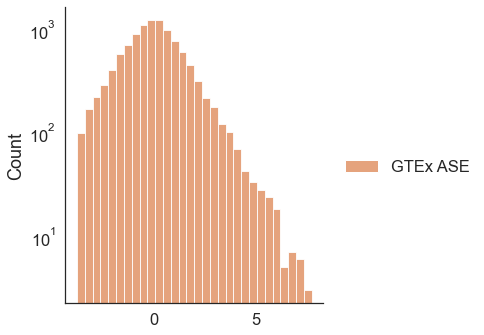

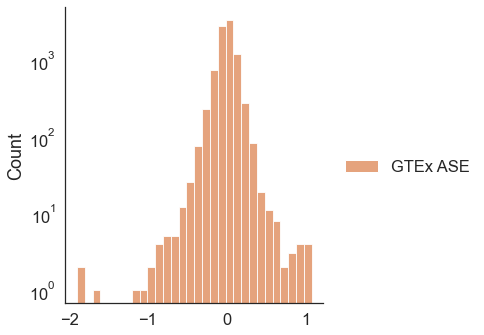

In [13]:
sns.set_style('white')
sns.displot({"GTEx ASE":ZNF331_their}, log_scale = (False, 10), palette = {"GTEx ASE":"#dd8452"}, bins = 30)
sns.displot({"GTEx ASE":EEF2_their}, log_scale = (False, 10), palette = {"GTEx ASE":"#dd8452"}, bins = 30)

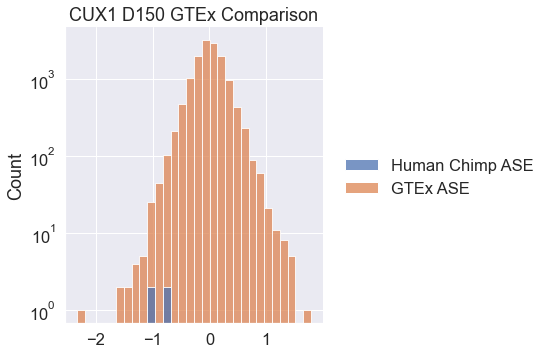

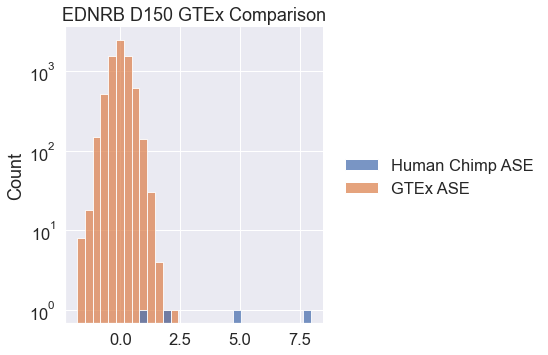

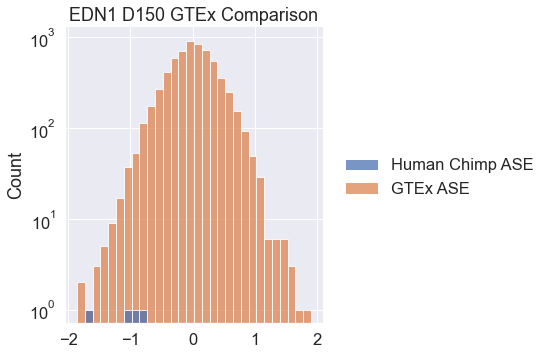

In [124]:
sns.set(font_scale = 1.5)
ax = sns.displot({"Human Chimp ASE":CUX1_our, "GTEx ASE":CUX1_their}, log_scale = (False, 10), bins = 30).set(title = "CUX1 D150 GTEx Comparison")
ax = sns.displot({"Human Chimp ASE":EDNRB_our, "GTEx ASE":EDNRB_their}, log_scale = (False, 10), bins = 30).set(title = "EDNRB D150 GTEx Comparison")
ax = sns.displot({"Human Chimp ASE":EDN1_our, "GTEx ASE":EDN1_their}, log_scale = (False, 10), bins = 30).set(title = "EDN1 D150 GTEx Comparison")

In [34]:
#Plot the distribution of a particular gene.
l1 = ["D150"]
l2 = ["Stein"]
keep_them = []
keep_our = []
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            if gene == "CUX1":
                CUX1_their = their_dist
                CUX1_our = our_dist
            if gene == "EDNRB":
                EDNRB_their = their_dist
                EDNRB_our = our_dist
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)
#EDN1 not available for Stein
#ax = sns.displot({"Human Chimp ASE":EDN1_our, "Stein ASE":EDN1_their}, log_scale = (False, 10), bins = 30).set(title = "EDN1 D150 Stein Comparison")

<ipython-input-34-0b27d1c7a889>:49: RuntimeWarning: invalid value encountered in log2
  their_dist = np.log2(their_dist)
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

Text(0.5, 12.84800000000002, 'log$_{2}$(ASE ratio)')

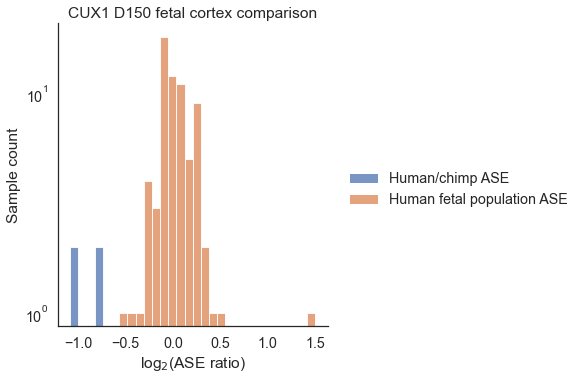

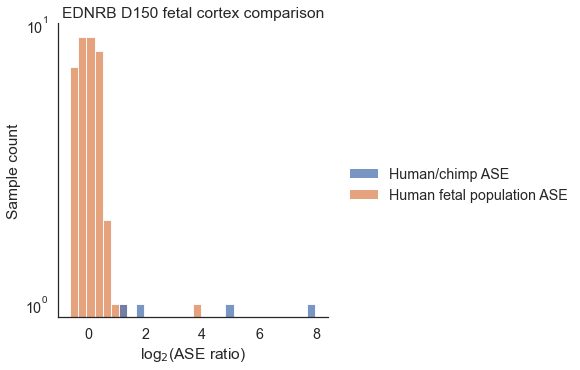

In [71]:
sns.set_style("white")
sns.set(font_scale = 1.3)
sns.set_style("white")
ax = sns.displot({"Human/chimp ASE":CUX1_our, "Human fetal population ASE":CUX1_their}, log_scale = (False, 10), bins = 30).set(title = "CUX1 D150 fetal cortex comparison", xlabel = "log2(ASE Ratio)", ylabel = "Sample count")
plt.xlabel("log$_{2}$(ASE ratio)")
ax = sns.displot({"Human/chimp ASE":EDNRB_our, "Human fetal population ASE":EDNRB_their}, log_scale = (False, 10), bins = 30).set(title = "EDNRB D150 fetal cortex comparison", xlabel = "log2(ASE Ratio)", ylabel = "Sample count")
plt.xlabel("log$_{2}$(ASE ratio)")

In [72]:
#Plot the distribution of a particular gene.
l1 = ["D150"]
l2 = ["GTEx"]
keep_them = []
keep_our = []
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            if gene == "CUX1":
                CUX1_their = their_dist
                CUX1_our = our_dist
            if gene == "EDN1":
                EDN1_their = their_dist
                EDN1_our = our_dist
            if gene == "EDNRB":
                EDNRB_their = their_dist
                EDNRB_our = our_dist
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)


C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\scipy\stats\stats.py:7171: RuntimeWarning: divide by zero encou

Text(0.5, 15.440000000000012, 'log$_{2}$(ASE ratio)')

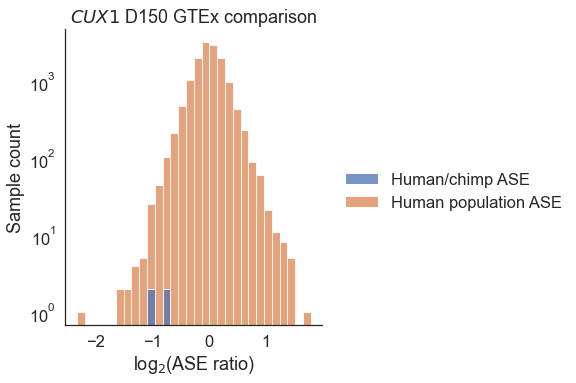

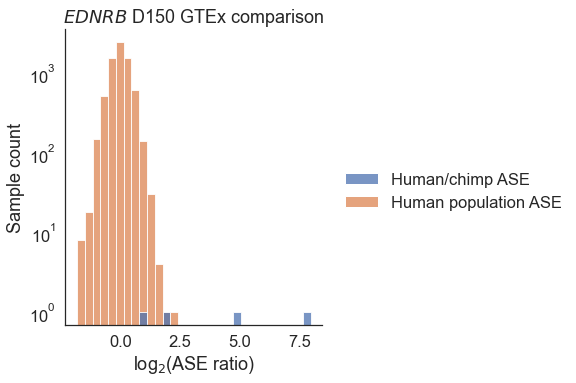

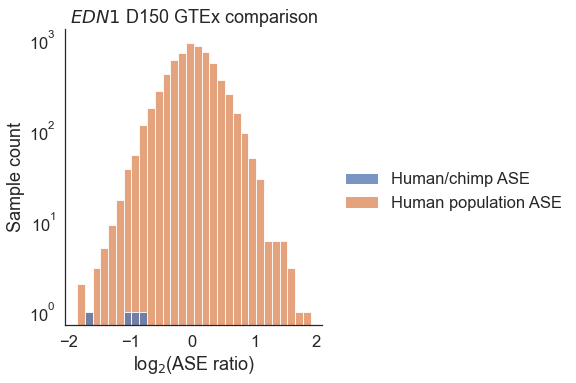

In [73]:
sns.set_style("white")
sns.set(font_scale = 1.5)
sns.set_style("white")
ax = sns.displot({"Human/chimp ASE":CUX1_our, "Human population ASE":CUX1_their}, log_scale = (False, 10), bins = 30).set(title = "$\it{CUX1}$ D150 GTEx comparison", xlabel = "log2(ASE Ratio)", ylabel = "Sample count")
plt.xlabel("log$_{2}$(ASE ratio)")
ax = sns.displot({"Human/chimp ASE":EDNRB_our, "Human population ASE":EDNRB_their}, log_scale = (False, 10), bins = 30).set(title = "$\it{EDNRB}$ D150 GTEx comparison", xlabel = "log2(ASE Ratio)", ylabel = "Sample count")
plt.xlabel("log$_{2}$(ASE ratio)")
ax = sns.displot({"Human/chimp ASE":EDN1_our, "Human population ASE":EDN1_their}, log_scale = (False, 10), bins = 30).set(title = "$\it{EDN1}$ D150 GTEx comparison", xlabel = "log2(ASE Ratio)", ylabel = "Sample count")
plt.xlabel("log$_{2}$(ASE ratio)")


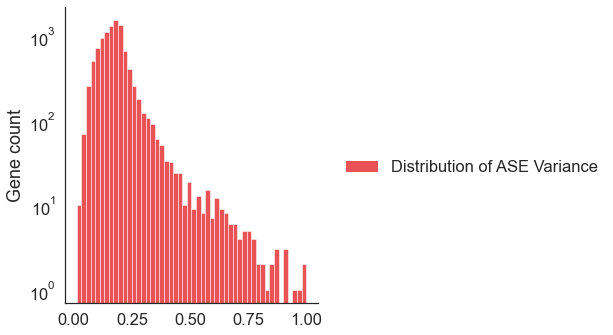

In [60]:
v = pd.read_csv("D150_GTEX_MinReads_Per_Allele10Variance_Mean.txt", sep = "\t")
pl = []
sns.set(font_scale=1.5)
sns.set_style("white")
for index, row in v.iterrows():
    if row[4] > 50 and row[1] > 0 and row[1] < 1:
        pl.append(row[1])
ax = sns.displot({"Distribution of ASE Variance": pl}, log_scale = (False, 10), bins = 50, palette = {"Distribution of ASE Variance": "#E31A1C"}).set(ylabel = "Gene count")
#ax.set_xticklabels()
#plt.xticks([1, 2, 3, 4, 5], ["0.00", "0.25", "0.5", "0.75", "1.00"])

In [20]:
#Trying with Just Brain
v = pd.read_csv("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep = "\t")
v_brain = v[v["SMTS"].isin(["Brain"])]
v_brain_ids = list(v_brain["SAMPID"])
order = pd.read_csv("GTEx_ID_With_CHECK.txt", sep = "\t")
c = 0
st = 0
brain_indices = []
for i in order.columns:
    if st < 4:
        st += 1
    else:
        if i in v_brain_ids:
            brain_indices.append(c)
        c += 1

In [21]:
l1 = ["D100"]
l2 = ["GTEX"]
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    vals_tex_1 = vals_tex_1[brain_indices]
                    #print(gene, vals_tex_1)
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    vals_tex_2 = vals_tex_2[brain_indices]
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            if gene == "NUDT14":
                NUDT14_their = their_dist
                NUDT14_our = our_dist
            if gene == "RPS16":
                RPS16_their = their_dist
                RPS16_our = our_dist
            if gene == "EEF2":
                EEF2_their = their_dist
                EEF2_our = our_dist
            if gene == "ZNF331":
                ZNF331_their = their_dist
                ZNF331_our = our_dist
            if gene == "RPS23":
                RPS23_their = their_dist
                RPS23_our = our_dist
            if gene == "PDPR":
                PDPR_their = their_dist
                PDPR_our = our_dist
            if gene == "HERC3":
                HERC3_their = their_dist
                HERC3_our = our_dist
            if gene == "FAM118A":
                FAM118A_their = their_dist
                FAM118A_our = our_dist
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele_JustBrain" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        #df.to_csv(cell + "_" + data + "_MinReads_Per_Allele_JustBrain" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)


C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\astar\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\astar\anaconda3\lib\site-packages\scipy\stats\stats.py:7171: RuntimeWarning: divide by zero encou

([<matplotlib.axis.XTick at 0x280d00d5520>,
 [Text(-5.0, 0, '−5.0'), Text(-2.5, 0, '−2.5'), Text(0.0, 0, '0.0')])

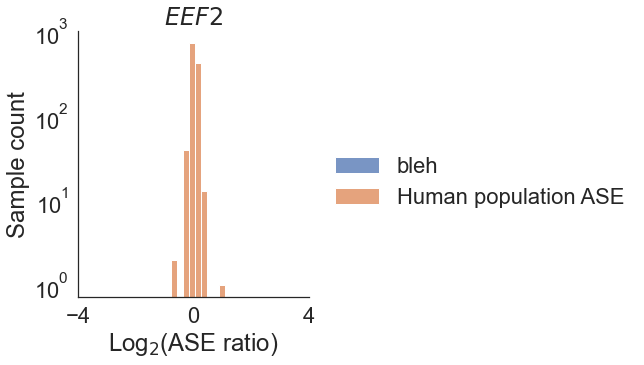

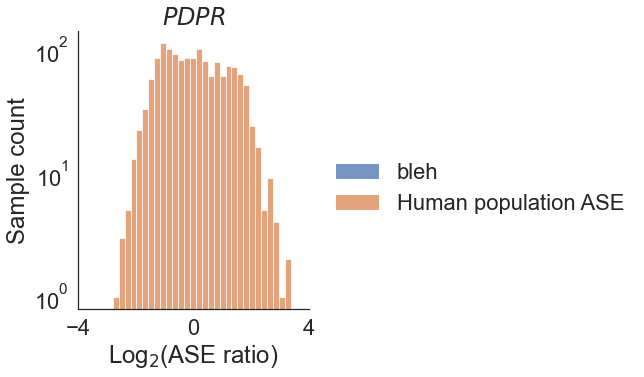

In [70]:
#ax = sns.displot({"bleh":l, "Human Population ASE":RPS23_their}, log_scale = (False, 10), bins = 30).set(title = "RPS23", ylabel = "Sample Count", xlabel = "log2(ASE Ratio)")
#plt.xticks([-4, 0, 4])
l= []
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.displot({"bleh":l, "Human population ASE":EEF2_their}, log_scale = (False, 10), bins = 9).set(title = "$\it{EEF2}$", ylabel = "Sample count", xlabel = "Log2(ASE ratio)")
plt.xticks([-4, 0, 4])
plt.xlabel("Log$_{2}$(ASE ratio)")
#ax = sns.displot({"bleh":l, "Human Population ASE":HERC3_their}, log_scale = (False, 10), bins = 30).set(title = "HERC3", ylabel = "Sample Count", xlabel = "log2(ASE Ratio)")
#plt.xticks([-5, 0, 5])
#ax = sns.displot({"bleh":l, "Human Population ASE":FAM118A_their}, log_scale = (False, 10), bins = 30).set(title = "FAM118A", ylabel = "Sample Count", xlabel = "log2(ASE Ratio)")
#plt.xticks([-5, 0, 5])
ax = sns.displot({"bleh":l, "Human population ASE":PDPR_their}, log_scale = (False, 10), bins = 30).set(title = "$\it{PDPR}$", ylabel = "Sample count", xlabel = "Log2(ASE ratio)")
plt.xlabel("Log$_{2}$(ASE ratio)")
plt.xticks([-4, 0, 4])

Text(0.5, 21.92, 'log$_{2}$(ASE ratio)')

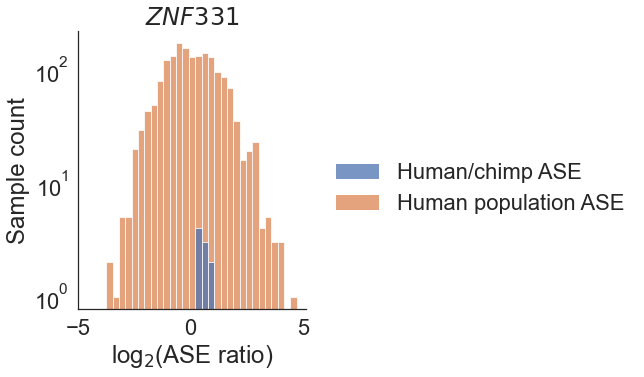

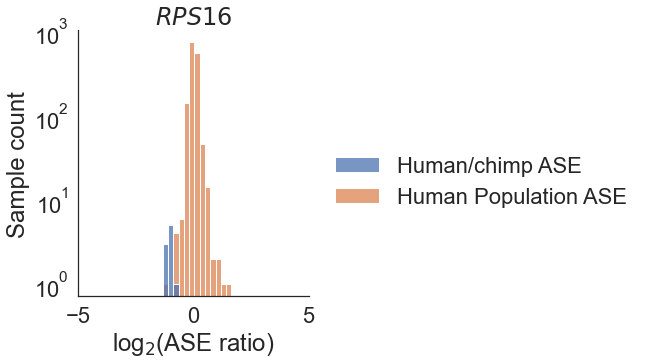

In [69]:
sns.set(font_scale = 2)
sns.set_style("white")
l = []
#ax = sns.displot({"Human Chimp ASE":NUDT14_our, "GTEx ASE":NUDT14_their}, log_scale = (False, 10), bins = 30).set(title = "NUDT14 D100 GTEx Comparison")
#ax = sns.displot({"Human Chimp ASE":APOD_our, "GTEx ASE":APOD_their}, log_scale = (False, 10), bins = 30).set(title = "APOD D100 GTEx Comparison")
#ax = sns.displot({"Human Chimp ASE":CUX1_our, "GTEx ASE":CUX1_their}, log_scale = (False, 10), bins = 30).set(title = "CUX1 D100 GTEx Comparison")
ax = sns.displot({"Human/chimp ASE":ZNF331_our, "Human population ASE":ZNF331_their}, log_scale = (False, 10), bins = 30).set(title = "$\it{ZNF331}$", ylabel = "Sample count", xlabel = "log2(ASE Ratio)")
plt.xticks([-5, 0, 5])
plt.xlabel("log$_{2}$(ASE ratio)")
ax = sns.displot({"Human/chimp ASE":RPS16_our, "Human Population ASE":RPS16_their}, log_scale = (False, 10), bins = 13).set(title = "$\it{RPS16}$", ylabel = "Sample count", xlabel = "log2(ASE Ratio)")
plt.xticks([-5, 0, 5])
plt.xlabel("log$_{2}$(ASE ratio)")
#ax = sns.displot({"bleh": l, "Human Population ASE":ZNF331_their}, log_scale = (False, 10), bins = 30).set(title = "ZNF331", ylabel = "Sample Count", xlabel = "log2(ASE Ratio)")
#ax = sns.displot({"bleh": l, "Human Population ASE":RPS16_their}, log_scale = (False, 10), bins = 30).set(title = "RPS16", ylabel = "Sample Count", xlabel = "log2(ASE Ratio)")


In [50]:
from scipy.stats import binom_test
print(binom_test(10, 10, 0.5))

0.001953125


In [11]:
v = pd.read_csv("D100_GTEX_MinReads_Per_Allele_JustBrain10Variance_Mean.txt", sep = "\t").set_index("gene")
v2 = pd.read_csv("Rachel_ASE_Values_D100.csv").set_index("Gene")
v3 = v.join(v2)
v3.to_csv("Find_Just_Brain_Cand.csv")

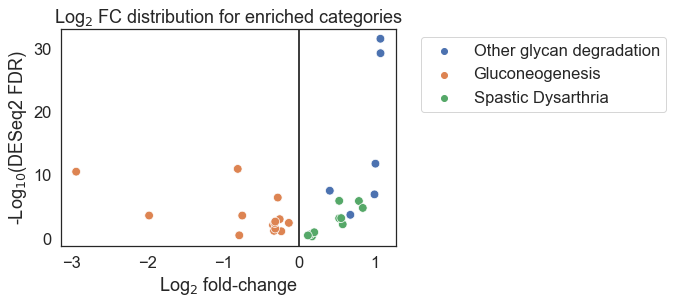

In [59]:
v = pd.read_csv("Ledge_genes_info_Other_Glycan_Degradation_D50_GTEX.csv")
l = []
for i, r in v.iterrows():
    l.append([-np.log10(r["DESeq2 p-val Score"]), r["L2FC signed"], "Other glycan degradation"])
v = pd.read_csv("Ledge_genes_info_Gluconeogenesis_D50_GTEX.csv")
for i, r in v.iterrows():
    l.append([-np.log10(r["DESeq2 p-val Score"]), r["L2FC signed"], "Gluconeogenesis"])
v = pd.read_csv("Ledge_genes_info_Spastic_Dysarthia_D100_GTEX.csv")
for i, r in v.iterrows():
    l.append([-np.log10(r["DESeq2 p-val Score"]), r["L2FC signed"], "Spastic Dysarthria"])
sns.set(font_scale = 1.5)
sns.set_style("white")
df = pd.DataFrame(l)
df.columns = ["-log10(DESeq2 FDR)", "Log2 Fold Change", "Type"]
ax = sns.scatterplot(data = df, x = "Log2 Fold Change", y = "-log10(DESeq2 FDR)", hue = "Type", s=75).set(title = "Log$_{2}$ FC distribution for enriched categories")
plt.xlabel("Log$_{2}$ fold-change")
plt.ylabel("-Log$_{10}$(DESeq2 FDR)")
plt.axvline(0, color = "black")
plt.legend(bbox_to_anchor=(1.05, 1))

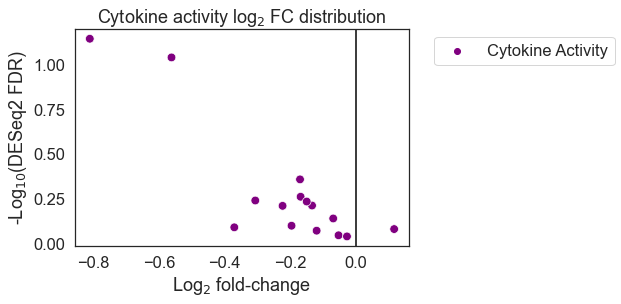

In [74]:
v = pd.read_csv("Ledge_genes_info_Cytokine_Activity_D150_GTEX.csv")
l = []
for i, r in v.iterrows():
    l.append([-np.log10(r["DESeq2 p-val Score"]), r["L2FC signed"], "Cytokine Activity"])
sns.set(font_scale = 1.5)
sns.set_style("white")
df = pd.DataFrame(l)
df.columns = ["-log10(DESeq2 FDR)", "Log2 Fold Change", "Category"]
ax = sns.scatterplot(data = df, x = "Log2 Fold Change", y = "-log10(DESeq2 FDR)", hue = "Category", palette = {"Cytokine Activity":"purple"}, s= 75).set(title = "Cytokine activity log$_{2}$ FC distribution")
plt.xlabel("Log$_{2}$ fold-change")
plt.ylabel("-Log$_{10}$(DESeq2 FDR)")
plt.axvline(0, color = "black")
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
#Need to restrict Rachel_ASE_NoNA to just genes in the Final_Linux file and then sort appropriately.

In [ ]:
#Trying it with the DESeq2 action.
l1 = ["D50", "D150", "D100"]
l2 = ["GTEX"]
for cell in l1:
    for data in l2:
        GTEX_1_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a1.txt", "r")
        GTEX_2_iPSC = open(data + "_" + cell + "_ASE_all_countmatrix_collapsed_gene_sorted_a2.txt", "r")
        David_iPSC = open(cell + "_Counts_" + data + "_Final_Linux.txt", "r")
        ind = 0
        count = 0
        output = []
        output_var = []
        min_reads = 10
        for line in David_iPSC:
            gene = 0
            count += 1
            our_dist = []
            vals = line.split("\t")
            gene = vals[0]
            for i in range(len(vals)):
                if i % 2 == 1:
                    c1 = int(vals[i]) + 1
                    c2 = int(vals[i+1]) + 1
                    totalCounts = c1 + c2
                    our_dist.append(c1/c2)
            for line in GTEX_1_iPSC:
                gene2 = line.split("\t")[1]
                assert(gene == gene2)
                if gene == gene2:
                    vals_tex_1 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            for line in GTEX_2_iPSC:
                gene3 = line.split("\t")[1]
                if gene == gene3:
                    vals_tex_2 = np.array([float(x) if x != "" and x != "\n" else 0 for x in line.split("\t")[4:]])
                    break
            z = np.add(vals_tex_1, vals_tex_2)
            check = np.intersect1d(np.where(vals_tex_1 >= min_reads), np.where(vals_tex_2 >= min_reads))
            vals_tex_1_fixed = vals_tex_1[check] + 1
            vals_tex_2_fixed = vals_tex_2[check] + 1
            their_dist = vals_tex_1_fixed/vals_tex_2_fixed
            med = np.median(their_dist)
            #Shift their distriubtion to make the median 1.
            their_dist = their_dist - (med - 1)
            #Now with logarithms because Hunter said so
            their_dist = np.log2(their_dist)
            our_dist = np.log2(our_dist)
            var = np.var(their_dist)
            mean_our = np.mean(our_dist)
            size = len(their_dist)
            try:
                p = mwu(our_dist, their_dist)[1]
                output.append([gene, p, size])
                output_var.append([gene, var, med, mean_our, size, var*size])
            except:
                pass
        df = pd.DataFrame(output)
        df.columns = ["gene", "pval", "Size"]
        to_test = list(df["pval"])
        fdr = pd.DataFrame(fdrcorrection(to_test)[1])
        df = df.join(fdr)
        df.columns = ["gene", "pval", "Sample Size", "fdr"]
        df = df.sort_values(by="pval", ascending=True)
        df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "MWU_ASE_Ratios_Median1.txt", sep = "\t", index = False)
        GTEX_1_iPSC.close()
        GTEX_2_iPSC.close()
        David_iPSC.close()
        df = pd.DataFrame(output_var)
        df.columns = ["gene", "Variance of ASE Dist", "Median of ASE Dist", "Mean of Our Dist", "Size", "Var*Size"]
        df.to_csv(cell + "_" + data + "_MinReads_Per_Allele" + str(min_reads) + "Variance_Mean.txt", sep = "\t", index = False)


In [11]:
v = pd.read_csv("D150_Counts_GTEx_Final_Linux.txt", sep = "\t")
v2 = list(pd.read_csv("Ledge_genes_info_Cytokine_Activity_D150_GTEX.csv")["Gene"])
out = []
for index, row in v.iterrows():
    if row[0] in v2:
        out.append(row)
df = pd.DataFrame(out)
df

,A1BG,66,53,246,39,209,99,152,98
898,BMP1,272,234,694,759,309,338,292,327
900,BMP3,17,19,27,44,10,27,10,10
901,BMP5,61,91,118,64,68,99,91,156
1831,CRLF1,215,211,133,240,338,397,616,715
2956,FGF2,299,440,486,541,245,289,274,322
3435,GREM2,95,69,107,115,65,134,63,160
3850,IL17D,184,193,197,441,183,220,186,186
3861,IL34,84,47,25,48,40,44,34,48
3889,INHBB,91,110,54,73,69,73,47,59
5554,NRG1,132,151,35,43,59,53,47,81


In [7]:
all_agree = ["BMP3", "FGF2", "IL17D", "INHBB", "SECTM1", "SP100", "TGFB3"]
three_agree = []

['CRLF1',
 'BMP5',
 'NRG1',
 'BMP3',
 'SPP1',
 'IL17D',
 'IL34',
 'INHBB',
 'FGF2',
 'GREM2',
 'TGFB1',
 'SP100',
 'TGFB3',
 'SECTM1',
 'BMP1']

<AxesSubplot:xlabel='Binomial p-val', ylabel='Count'>

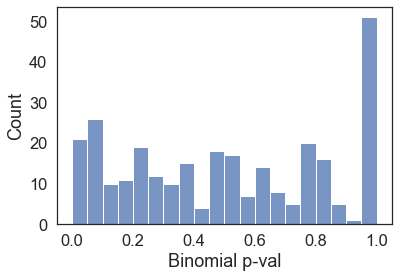

In [15]:
v = pd.read_csv("AGSEA_MWU_p-val_DESeq2_p-val_Rank_Rank_Dif_Combined_SignTest_Fixed.csv")
sns.histplot(data = v, x = "Binomial p-val", bins = 20)

In [12]:
v["Binomial p-val"]

0      0.000802
1      0.000878
2      0.000519
3      0.003418
4      0.008130
         ...   
285    0.774414
286    0.774414
287    1.000000
288    0.790527
289    0.774414
Name: Binomial p-val, Length: 290, dtype: float64

In [53]:
#House keeping genes generally have lower ASE variance than other genes.
v = pd.read_csv("HK_genes.txt", sep = "\t", header= None)
v.columns = ["gene", "id"]
vl = list(v["gene"])
vll = []
for i in vl:
    vll.append(i.replace(" ", ""))
v2 = pd.read_csv("D150_GTEX_MinReads_Per_Allele_Both10Variance_Mean.txt", sep = "\t").set_index("gene")
#v = v.join(v2)

In [54]:
z1 = []
z2 = []
for index, row in v2.iterrows():
    if row["Variance of ASE Dist"] < 1:
        if index in vll:
            z1.append(row["Variance of ASE Dist"])
        else:
            z2.append(row["Variance of ASE Dist"])

<AxesSubplot:ylabel='Count'>

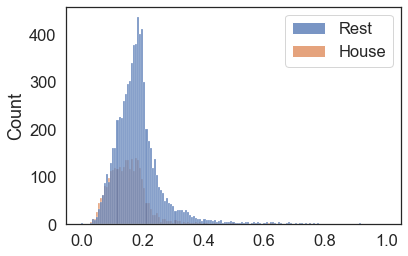

In [55]:
sns.histplot({"Rest":z2, "House":z1})

In [51]:
z1

[]

In [56]:
print(np.median(z1), np.median(z2))

0.14922527634758254 0.1800995583948286


In [57]:
print(mwu(z1, z2))

MannwhitneyuResult(statistic=7230026.0, pvalue=1.6335571266829617e-118)
